<a href="https://colab.research.google.com/github/cpappas18/Articulaite/blob/main/Random_forest_classifier_on_datasets_without_onehot_encoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.ensemble import RandomForestClassifier
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from sklearn.model_selection import train_test_split



In [ ]:
import pandas as pd
df = pd.read_csv('all_disorders_remove_std.csv')
df.tail()

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
6679,0,1,-32.217900,-20.908653,-23.684420,-31.694701,-22.688858,-7.370397,-13.781598,-10.612545,-23.216192,-23.194185
6680,0,1,-1.059601,18.348724,-2.716940,-3.364087,-1.038437,-2.693716,0.433780,4.189205,-4.254203,-1.252287
6681,0,1,35.218278,-0.558297,42.491249,30.454924,-16.763825,1.337682,-16.327157,-16.064503,-18.499916,-14.613771
6682,0,1,2.792539,-3.296699,1.430399,7.347828,-18.280037,-2.884069,-19.637068,-25.929862,-28.065778,-19.527662
6683,0,1,-4.198662,20.934973,-18.593052,-15.748143,21.101617,5.038021,27.616431,14.668735,17.824521,-10.922711


Smote function

In [ ]:
import pandas as pd
import numpy as np
from collections import Counter
from imblearn.over_sampling import SMOTE
from numpy import where, random

def smote_multiclass(df, num_samples_dict, one_hot_encoded):
  """
  Performs data augmentation and/or downsampling on a dataframe with multiple classes.
  Supports both numerical and one-hot encoded class values.
  The SMOTE algorithm is used for augmentation and random sampling is used for downsampling of the specified classes.
  Keyword arguments:
  df -- the dataframe to manipulate
  num_samples_dict -- a dictionary of the form {0: num_desired_samples, 1: num_desired_samples, ...} that indicates the
                      number of samples that the returned dataframe should have in each class
  one_hot_encoded -- Boolean value indicating if the dataframe is one-hot encoded
  """

  if df.columns[[0]] == 'Unnamed: 0':
    df.drop(df.columns[[0]], axis=1, inplace=True)  # remove first column

  # change one hot encoded dataset into numerical labels
  if one_hot_encoded:
    df.insert(loc=0, column='Status', value=np.nan)
    for i, row in df.iterrows():
      if df.iloc[i]['Control'] == 1:
          status = 0
      elif df.iloc[i]['Parkinsons'] == 1:
          status = 1
      elif df.iloc[i]['ALS'] == 1:
          status = 2
      elif df.iloc[i]['Cerebral_palsy'] == 1:
          status = 3
      df.at[i,'Status'] = status
    df = df.drop(columns=['Control', 'Parkinsons', 'ALS', 'Cerebral_palsy'])


  if num_samples_dict is not None:
    strategy = num_samples_dict

    # downsampling classes if needed
    counter = Counter(df.Status)
    class_samples = []
    for i in range(4):
      if counter[i] > num_samples_dict[i]: # class i needs to be downsampled
        class_i = df.loc[df['Status'] == i]
        class_i_sample = class_i.sample(n=num_samples_dict[i])
        class_samples.append(class_i_sample)
      else: # class i does not need downsampling
        class_i = df.loc[df['Status'] == i]
        class_samples.append(class_i)

    df = pd.concat(class_samples).reset_index(drop=True)

  else:
    strategy = 'auto'

  y = df.Status # labels
  x = df.drop(['Status', 'Gender'], axis=1) # features only, Gender also removed because it must be binary
  gender = df.Gender

  oversample = SMOTE(sampling_strategy=strategy)
  x_oversampled, y_oversampled = oversample.fit_resample(x, y)

  # get sample counts for augmented dataset
  counter = Counter(y_oversampled)

  if num_samples_dict is not None and (counter[0] != num_samples_dict[0] or counter[1] != num_samples_dict[1]
                                       or counter[2] != num_samples_dict[2] or counter[3] != num_samples_dict[3]):
    print("Sampling failed")
  elif num_samples_dict is None and (counter[0] != counter[1] or counter[1] != counter[2] or counter[2] != counter[3]):
    print("Sampling failed")

  # regenerate dataframe with new samples
  df_concat = pd.concat([pd.DataFrame(y_oversampled), pd.DataFrame(gender), pd.DataFrame(x_oversampled)], axis=1)
  df_concat.columns = df.columns

  # fill missing gender values with a random choice of 0 or 1
  for row in df_concat.loc[df_concat.Gender.isnull(), 'Gender'].index:
    df_concat.at[row, 'Gender'] = random.randint(0, 2)

  # change numerical class values back into one-hot encoded values
  if one_hot_encoded:
    one_hot = pd.get_dummies(df_concat['Status'])
    one_hot.rename(columns={0:'Control', 1:'Parkinsons', 2:'ALS', 3:'Cerebral_palsy'}, inplace=True)
    df_concat = df_concat.drop(columns=['Status'], axis=1)
    df_concat = pd.concat([one_hot, df_concat], axis=1)

  return df_concat

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
#function to get TP,TN,FP,FN
def perf_measure(y_actual, y_hat):
    
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    #0=HC, 1= PD, 2 = ALS, 3= CP
    for i in range(len(y_hat)): 
        #actually positive and predicts positive 
        if y_actual[i]==y_hat[i] and y_actual[i] != 0:
           TP += 1
           #actually healthy but predicted otherwise 
        elif y_actual[i]==0 and y_hat[i]!=y_actual[i]:
           FP += 1
           #actuall negative and predicts neg
        elif y_actual[i]== 0 and y_hat[i]==y_actual[i]:
           TN += 1
           #actual positive but predicts negative 
        elif y_actual[i] !=0 and y_hat[i] == 0:
           FN += 1
    return TP, FP, TN, FN

Getting features and splitting data 

In [ ]:

features = df.drop(['Status'], axis = 1)
labels = df.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [ ]:
x = features 
y = labels 

In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x, y, test_size=0.2, stratify=y)

Without SMOTE

In [ ]:
model_without_smote = RandomForestClassifier(n_estimators = 1000)
model_without_smote.fit(x_train, y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
ypred_ns = model_without_smote.predict(x_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred_ns, y_test))

              precision    recall  f1-score   support

           0       0.47      0.77      0.58        26
           1       1.00      0.98      0.99      1304
           2       1.00      0.50      0.67         6
           3       0.33      1.00      0.50         1

    accuracy                           0.98      1337
   macro avg       0.70      0.81      0.68      1337
weighted avg       0.99      0.98      0.98      1337



In [ ]:
print(accuracy_score(y_test, ypred_ns)*100)

97.75617053103964


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, model_without_smote.predict_proba(x_test), multi_class='ovr')


0.9926576700259044

In [ ]:
from itertools import chain

ypred_ns_list = ypred_ns.tolist()
y_test_list = y_test.values.tolist()

#changing from 2d list into 1d list 
y_test_list = list(chain.from_iterable(y_test_list))


TP, TN, FP, FN = perf_measure(y_test_list, ypred_ns_list)

NameError: ignored

In [ ]:
print(TP, TN, FP, FN)

1287 23 7 20


With SMOTE

In [ ]:
pre_smote_training_dataset = pd.concat([y_train, x_train], axis=1, join='inner')

In [ ]:
pre_smote_training_dataset

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
6235,1,0,-0.065708,-0.000548,-0.040195,-0.110347,0.146506,0.280735,0.125229,0.108941,0.069918,0.097964
1377,1,0,-0.038051,-0.000197,-0.027605,-0.079216,-0.416591,-0.924529,-0.238931,-0.271532,-0.331488,0.037771
3576,1,0,0.003857,0.000108,0.003189,0.009969,0.028613,-0.009690,0.021584,0.030579,-0.000565,0.223849
2227,1,0,-0.021084,-0.000030,-0.013825,-0.028398,-0.242934,-0.503413,-0.131495,-0.143791,-0.196369,0.361695
2060,1,0,-0.062314,-0.000473,-0.032199,-0.088976,-0.398104,-0.884596,-0.218993,-0.265866,-0.308889,-0.598019
...,...,...,...,...,...,...,...,...,...,...,...,...
1555,1,0,-0.025665,-0.000113,-0.017908,-0.054480,-0.223690,-0.510673,-0.138581,-0.153829,-0.147379,0.067193
2277,1,1,-0.024817,-0.000352,-0.016547,-0.015440,-0.177169,-0.343679,-0.074812,-0.116915,-0.170768,-0.194127
2156,1,0,-0.002081,0.000264,0.002848,-0.035297,-0.023666,-0.045993,-0.013020,-0.005849,0.036731,0.571503
357,1,0,-0.053831,-0.000432,-0.028456,-0.084937,-0.345977,-0.757535,-0.188673,-0.221019,-0.283762,-0.779756


In [ ]:
pre_smote_training_dataset.reset_index(inplace = True)
pre_smote_training_dataset.drop(['index'],axis = 1, inplace = True)

In [ ]:
pre_smote_training_dataset

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,1,0,-0.065708,-0.000548,-0.040195,-0.110347,0.146506,0.280735,0.125229,0.108941,0.069918,0.097964
1,1,0,-0.038051,-0.000197,-0.027605,-0.079216,-0.416591,-0.924529,-0.238931,-0.271532,-0.331488,0.037771
2,1,0,0.003857,0.000108,0.003189,0.009969,0.028613,-0.009690,0.021584,0.030579,-0.000565,0.223849
3,1,0,-0.021084,-0.000030,-0.013825,-0.028398,-0.242934,-0.503413,-0.131495,-0.143791,-0.196369,0.361695
4,1,0,-0.062314,-0.000473,-0.032199,-0.088976,-0.398104,-0.884596,-0.218993,-0.265866,-0.308889,-0.598019
...,...,...,...,...,...,...,...,...,...,...,...,...
5342,1,0,-0.025665,-0.000113,-0.017908,-0.054480,-0.223690,-0.510673,-0.138581,-0.153829,-0.147379,0.067193
5343,1,1,-0.024817,-0.000352,-0.016547,-0.015440,-0.177169,-0.343679,-0.074812,-0.116915,-0.170768,-0.194127
5344,1,0,-0.002081,0.000264,0.002848,-0.035297,-0.023666,-0.045993,-0.013020,-0.005849,0.036731,0.571503
5345,1,0,-0.053831,-0.000432,-0.028456,-0.084937,-0.345977,-0.757535,-0.188673,-0.221019,-0.283762,-0.779756


In [ ]:
smoted_training_data = smote_multiclass(pre_smote_training_dataset, num_samples_dict={0:5500, 1:5500, 2:5500, 3:5500}, one_hot_encoded=False )

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (5500) in class 0 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (5500) in class 1 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (5500) in class 2 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (5500) in class 3 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_sam

In [ ]:
smoted_training_data

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,0,1.0,-0.074021,-0.000550,-0.040875,-0.124482,0.156961,0.262584,0.113530,0.150226,0.126336,0.697195
1,0,1.0,-0.079620,-0.000597,-0.045469,-0.130876,-0.114889,-0.296485,-0.031145,-0.092953,-0.112611,-0.303323
2,0,0.0,-0.085898,-0.000647,-0.047681,-0.133400,0.139838,0.229911,0.058824,0.213692,0.057749,0.221052
3,0,0.0,-0.087934,-0.000660,-0.048702,-0.134915,-0.202020,-0.499782,-0.085193,-0.126629,-0.210750,-0.834257
4,0,0.0,-0.087425,-0.000655,-0.048361,-0.134410,0.048767,0.088329,0.091120,-0.001477,-0.062198,0.051855
...,...,...,...,...,...,...,...,...,...,...,...,...
21995,3,1.0,-4.908699,-0.202877,-7.034061,-0.191377,-4.959159,-3.720423,-1.579238,-1.170402,-0.866328,-6.532949
21996,3,1.0,-4.760791,-2.051911,-3.005764,-5.021867,-6.029782,-2.557931,-7.692684,-4.505871,-3.697267,-6.192358
21997,3,1.0,-6.228035,-9.892052,-4.797347,-4.359743,-5.422475,-3.074581,-6.745211,-5.299926,-6.553259,-5.873551
21998,3,1.0,-17.679915,-5.207788,-13.150402,-14.755457,-9.773750,-0.809436,-14.680533,-12.824639,-7.237168,-11.387592


In [ ]:
new_x_train = smoted_training_data.drop(['Status'], axis = 1)
new_y_train = smoted_training_data.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [ ]:
model = RandomForestClassifier(n_estimators=1000)
model.fit(new_x_train, new_y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


KeyboardInterrupt: ignored

In [ ]:
ypred = model.predict(x_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(ypred, y_test))

              precision    recall  f1-score   support

           0       0.72      0.41      0.52        76
           1       0.97      0.99      0.98      1257
           2       0.33      1.00      0.50         1
           3       0.33      0.33      0.33         3

    accuracy                           0.96      1337
   macro avg       0.59      0.68      0.58      1337
weighted avg       0.95      0.96      0.95      1337



In [ ]:
print(accuracy_score(y_test, ypred)*100)

95.73672400897532


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, model.predict_proba(x_test), multi_class='ovr')



0.972961970957809

In [ ]:
from itertools import chain

ypred_list = ypred.tolist()
y_test_list = y_test.values.tolist()

#changing from 2d list into 1d list 
y_test_list = list(chain.from_iterable(y_test_list))
TP, FP, TN, FN = perf_measure(y_test_list, ypred_list)

In [ ]:
print(TP,FP,TN,FN)

1249 12 31 45


In [ ]:
import csv
import matplotlib.pyplot as plt
import os
import secrets  # to generate jpg name

def performance_report(model, X, y, X_test, y_test, y_pred, model_label):

  # classification accuracy
  try:
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
  except:
    accuracy = "NA"

  # confusion matrix
  from sklearn.metrics import confusion_matrix
  from sklearn.metrics import plot_confusion_matrix
  from sklearn.model_selection import cross_val_score, KFold
  
  try:
    conf = confusion_matrix(y_test, y_pred)
    TP = conf[1][1]
    TN = conf[0][0]
    FP = conf[0][1]
    FN = conf[1][0]

    disp = plot_confusion_matrix(model, X_test, y_test, cmap=plt.cm.Blues, values_format='.0f')
    title = secrets.token_hex(4)
    plt.savefig(title, format="jpg")

    path1 = os.path.abspath(title+".jpg")
  except:
    TP = TN = FP = FN = path1 = ""

  # k-fold cross validation
  from sklearn import model_selection
  try:
    kfold = model_selection.KFold(n_splits=6, shuffle=True)
    KCV = model_selection.cross_val_score(model, X, y, cv=kfold, scoring='accuracy').mean()
  except:
    KCV = ""

  # log loss (closer to 0 is better)
  try:
    logloss = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='neg_log_loss').mean()
  except:
    logloss = ""

  # AUC (1 is perfect predictions, 0.5 is as good as random)
  try:
    AUC = model_selection.cross_val_score(model, x_train, y_train, cv=kfold, scoring='roc_auc').mean()
  except:
    AUC = ""

  # precision recall curve
  from sklearn.metrics import plot_precision_recall_curve
  from sklearn.metrics import average_precision_score

  try:
    y_score = model.decision_function(X_test)
    average_precision = average_precision_score(y_test, y_score)

    disp = plot_precision_recall_curve(model, x_test, y_test)
    title = secrets.token_hex(4)  
    plt.savefig(title, format="jpg")

    path2 = os.path.abspath(title+".jpg")
  except:
    average_precision = path2 = ""

  # appending metrics to csv file
  with open('metrics.csv', 'a', newline='') as file:
    writer = csv.writer(file)
    if os.stat("metrics.csv").st_size == 0:
      writer.writerow(["Model label", "Accuracy score", "TP", "TN", "FP", "FN", "Confusion matrix file","KCV", "Log-loss", "AUC", "Average precision", "Precision-recall file"])
    writer.writerow([model_label, accuracy, TP, TN, FP, FN, path1, KCV, logloss, AUC, average_precision, path2])


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

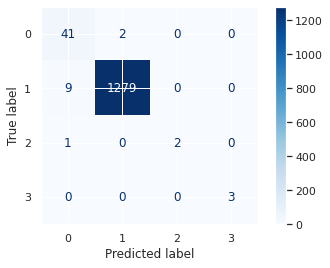

In [ ]:
model_label = 'Randomforest_alldisorders_remove'
performance_report(model, new_x_train, new_y_train, x_test, y_test, ypred, model_label)

In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model2, new_x_train, new_y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)


KeyboardInterrupt: ignored

In [ ]:
scores = cross_val_score(model, new_x_train, new_y_train, cv=5)
print("Mean cross-validation score: %.2f" % scores.mean())


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

Mean cross-validation score: 0.95


***Median Dataset***

In [ ]:
import pandas as pd
data = pd.read_csv('all_disorders_median_std.csv')
data.tail()

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
7114,0,1,-33.243298,-21.578308,-24.440050,-32.691854,-23.328592,-7.466749,-14.202938,-10.933402,-23.923671,-23.417656
7115,0,1,-1.091966,18.936385,-2.803416,-3.468182,-1.064890,-2.724605,0.447177,4.317949,-4.380995,-1.267387
7116,0,1,36.342110,-0.576181,43.847541,31.416897,-17.235723,1.363223,-16.826345,-16.550963,-19.062965,-14.755758
7117,0,1,2.882944,-3.402288,1.476280,7.581402,-18.794885,-2.917623,-20.237481,-26.715980,-28.921770,-19.716314
7118,0,1,-4.331071,21.605465,-19.186196,-16.242616,21.702316,5.115358,28.461133,15.115793,18.373862,-11.029646


In [ ]:
features = data.drop(['Status'], axis = 1)
labels = data.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [ ]:
X = features 
Y = labels 
X_train,X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.2, stratify=Y)

Without Smote

In [ ]:
model_without_smote2 = RandomForestClassifier()
model_without_smote2.fit(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred_ns2 = model_without_smote2.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(y_pred_ns2, Y_test))

              precision    recall  f1-score   support

           0       0.71      0.87      0.79        63
           1       1.00      0.98      0.99      1358
           2       0.33      0.50      0.40         2
           3       0.33      1.00      0.50         1

    accuracy                           0.98      1424
   macro avg       0.59      0.84      0.67      1424
weighted avg       0.98      0.98      0.98      1424



In [ ]:
print(accuracy_score(Y_test, y_pred_ns2)*100)

97.82303370786516


In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(Y_test, model_without_smote2.predict_proba(X_test), multi_class='ovr')


0.9913613873649347

In [ ]:
from itertools import chain
y_pred_ns2_list = y_pred_ns2.tolist()

Y_test_list = Y_test.values.tolist()

#changing from 2d list into 1d list 
Y_test_list = list(chain.from_iterable(Y_test_list))

TP,TN,FP,FN = perf_measure(Y_test_list, y_pred_ns2_list)

In [ ]:
print(TP, TN, FP, FN)

1338 22 55 8


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model_without_smote2, X_train, Y_train, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

K-fold CV average score: 0.97


With SMOTE 

In [ ]:
pre_smote_training_dataset_median = pd.concat([Y_train, X_train], axis=1, join='inner')

In [ ]:
pre_smote_training_dataset_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
5259,1,0,-0.024987,-0.000323,-0.014165,-0.041355,-0.133376,-0.281963,-0.041856,-0.081620,-0.161444,-0.675189
6421,1,0,-0.085389,-0.000628,-0.046490,-0.131044,0.471089,0.955974,0.369101,0.272625,0.167267,0.874301
5594,1,1,0.084281,0.000281,0.029899,0.146607,-0.039577,-0.096817,-0.008571,-0.091820,-0.033278,0.589252
3486,1,0,0.020315,0.000427,0.004720,0.002228,0.476090,0.894259,0.283416,0.317311,0.355485,0.198093
3875,1,0,-0.030416,-0.000275,-0.025904,-0.088303,-0.080491,-0.085926,-0.120455,-0.075791,0.100734,-0.351748
...,...,...,...,...,...,...,...,...,...,...,...,...
5544,1,1,-0.007680,-0.000176,-0.010082,0.005594,-0.155197,-0.379982,-0.070857,-0.113838,-0.128098,-0.607858
4416,1,1,0.026084,-0.000192,0.017990,0.038912,0.050282,0.110111,0.023396,0.016818,0.098364,-0.260011
6200,1,1,-0.043141,-0.000519,-0.039004,-0.124650,0.342135,0.995908,0.093921,0.205273,0.482386,0.665458
211,1,0,0.008438,0.000194,0.004550,0.044128,0.047858,0.015722,0.062449,-0.002611,-0.086061,1.397326


In [ ]:
pre_smote_training_dataset_median.reset_index(inplace = True)
pre_smote_training_dataset_median.drop(['index'],axis = 1, inplace = True)

In [ ]:
pre_smote_training_dataset_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,1,0,-0.024987,-0.000323,-0.014165,-0.041355,-0.133376,-0.281963,-0.041856,-0.081620,-0.161444,-0.675189
1,1,0,-0.085389,-0.000628,-0.046490,-0.131044,0.471089,0.955974,0.369101,0.272625,0.167267,0.874301
2,1,1,0.084281,0.000281,0.029899,0.146607,-0.039577,-0.096817,-0.008571,-0.091820,-0.033278,0.589252
3,1,0,0.020315,0.000427,0.004720,0.002228,0.476090,0.894259,0.283416,0.317311,0.355485,0.198093
4,1,0,-0.030416,-0.000275,-0.025904,-0.088303,-0.080491,-0.085926,-0.120455,-0.075791,0.100734,-0.351748
...,...,...,...,...,...,...,...,...,...,...,...,...
5342,1,1,-0.007680,-0.000176,-0.010082,0.005594,-0.155197,-0.379982,-0.070857,-0.113838,-0.128098,-0.607858
5343,1,1,0.026084,-0.000192,0.017990,0.038912,0.050282,0.110111,0.023396,0.016818,0.098364,-0.260011
5344,1,1,-0.043141,-0.000519,-0.039004,-0.124650,0.342135,0.995908,0.093921,0.205273,0.482386,0.665458
5345,1,0,0.008438,0.000194,0.004550,0.044128,0.047858,0.015722,0.062449,-0.002611,-0.086061,1.397326


In [ ]:
smoted_training_data_median = smote_multiclass(pre_smote_training_dataset_median, num_samples_dict={0:6500, 1:6500, 2:6500, 3:6500}, one_hot_encoded=False)

/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6500) in class 0 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6500) in class 1 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6500) in class 2 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_samples_majority))
/usr/local/lib/python3.7/dist-packages/imblearn/utils/_validation.py:257: UserWarning: After over-sampling, the number of samples (6500) in class 3 will be larger than the number of samples in the majority class (class #1 -> 5151)
  n_sam

In [ ]:
smoted_training_data_median

,Status,Gender,MDVP:Jitter(%),MDVP:Jitter(Abs),Jitter:PPQ5,Jitter:DDP,MDVP:Shimmer,MDVP:Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,DFA
0,0,1.0,-0.052813,-0.000260,-0.024203,-0.093519,0.109077,0.215390,0.023067,0.106026,0.398154,1.031440
1,0,1.0,-0.079620,-0.000597,-0.045469,-0.130876,-0.114889,-0.296485,-0.031145,-0.092953,-0.112611,-0.303323
2,0,1.0,26.357222,-7.088279,34.360104,27.118943,-14.234334,0.663513,-16.387642,-21.217054,-15.774238,-7.275256
3,0,0.0,-0.073512,-0.000584,-0.040875,-0.124650,0.067860,0.153674,0.021748,0.050494,0.059646,1.354496
4,0,1.0,-0.005984,0.000028,-0.016036,-0.044384,0.230455,0.121002,0.141542,0.025075,-0.042286,-0.229143
...,...,...,...,...,...,...,...,...,...,...,...,...
25995,3,0.0,-7.403246,-10.536998,-8.049711,-4.819788,-7.612966,-4.122659,-6.275613,-7.438036,-5.075346,-9.876837
25996,3,0.0,-1.944431,13.740716,-2.190562,-2.264454,-5.748095,-2.296986,-4.653934,0.097203,3.359733,-6.075778
25997,3,1.0,9.150512,1.293085,5.413679,11.183539,14.848759,1.595534,10.044673,12.494215,23.606146,-5.503358
25998,3,0.0,-26.919582,-19.362978,-22.181498,-25.207072,0.487500,-3.372498,-0.872316,10.551904,17.527561,-19.408354


In [ ]:
new_X_train_median = smoted_training_data_median.drop(['Status'], axis = 1)
new_Y_train_median = smoted_training_data_median.drop(['Gender', 'MDVP:Jitter(%)', 'MDVP:Jitter(Abs)', 'Jitter:PPQ5', 'Jitter:DDP', 'MDVP:Shimmer', 'MDVP:Shimmer(dB)', 'Shimmer:APQ3', 'Shimmer:APQ5', 'Shimmer:APQ11', 'DFA'],axis = 1)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

               

In [ ]:
rf_random = RandomizedSearchCV(estimator = RandomForestClassifier(), param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)


In [ ]:
rf_random.fit(new_X_train_median,new_Y_train_median)
rf_random.best_params_

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  8.7min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 50,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 200}

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [60, 50, 70, 80],
    'max_features': ['sqrt'],
    'min_samples_leaf': [1,2,3],
    'min_samples_split': [1,4,3,2],
    'n_estimators': [100,300,500]
}
# Create a based model
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = RandomForestClassifier(), param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)


In [ ]:
grid_search.fit(new_X_train_median, new_Y_train_median)
grid_search.best_params_

Fitting 3 folds for each of 144 candidates, totalling 432 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  49 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 170 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 373 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 432 out of 432 | elapsed:  2.8min finished
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:739: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

Optimal Parameters: {'bootstrap': True,
 'max_depth': 70,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 100}

In [ ]:
model2 = RandomForestClassifier(n_estimators=100, max_depth=70, bootstrap=True, max_features='sqrt', min_samples_leaf=1, min_samples_split=3)
model2.fit(new_X_train_median, new_Y_train_median)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=70, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
Y_pred = model2.predict(X_test)

In [ ]:
from sklearn import metrics
print(metrics.classification_report(Y_pred, Y_test))

              precision    recall  f1-score   support

           0       0.86      0.46      0.60        80
           1       0.97      1.00      0.98      1252
           2       0.67      1.00      0.80         2
           3       0.67      0.67      0.67         3

    accuracy                           0.96      1337
   macro avg       0.79      0.78      0.76      1337
weighted avg       0.96      0.96      0.96      1337



In [ ]:
roc_auc_score(Y_test, model2.predict_proba(X_test), multi_class='ovr')

0.9875999086122598

In [ ]:
print(accuracy_score(Y_test, Y_pred)*100)

96.33507853403141


In [ ]:
Y_pred_list = Y_pred.tolist()

Y_test_list = Y_test.values.tolist()

#changing from 2d list into 1d list 
Y_test_list = list(chain.from_iterable(Y_test_list))

TP,FP, TN, FN = perf_measure(Y_test_list, Y_pred_list)

In [ ]:
print(TP, FP, TN , FN)

1251 6 37 43


In [ ]:
kfold = KFold(n_splits=10, shuffle=True)
kf_cv_scores = cross_val_score(model2, new_X_train_median, new_Y_train_median, cv=kfold )
print("K-fold CV average score: %.2f" % kf_cv_scores.mean())

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

K-fold CV average score: 0.99


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:515: DataConversionWarning: A column-vector y was passed when a 

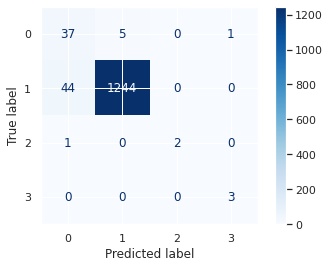

In [ ]:
model_label = 'Randomforest_alldisorders_median'
performance_report(model2, new_X_train_median, new_Y_train_median, X_test, Y_test, Y_pred, model_label)